基底関数やカットオフがどのような形状をしているかを確認する

In [1]:
from util import *


動作確認

In [2]:
# test_radial_envelope.py
import math
import torch
import torch.nn.functional as F

from util import make_radial, make_envelope

def assert_all_finite(x: torch.Tensor, name: str):
    if not torch.isfinite(x).all():
        bad = (~torch.isfinite(x)).nonzero(as_tuple=False).flatten()[:10]
        raise RuntimeError(f"[{name}] has non-finite values at indices: {bad.tolist()}")

def basic_stats(x: torch.Tensor):
    return dict(
        shape=tuple(x.shape),
        min=float(x.min().item()),
        max=float(x.max().item()),
        mean=float(x.mean().item()),
        std=float(x.std().item()),
    )

def check_envelope_endpoints(r: torch.Tensor, f: torch.Tensor, rc: float, name: str, tol=5e-2):
    """f: (E,) 期待値: r=0 付近で ~1, r>=rc で 0"""
    i0 = (r <= (0.01*rc)).nonzero(as_tuple=False).flatten()
    i1 = (r >= rc).nonzero(as_tuple=False).flatten()
    if i0.numel():
        v0 = float(f[i0].mean().item())
        if not (1.0 - tol <= v0 <= 1.0 + tol):
            print(f"[WARN] envelope {name}: near r=0 expected ~1, got {v0:.4f}")
    if i1.numel():
        v1 = float(f[i1].abs().max().item())
        if v1 > tol:
            print(f"[WARN] envelope {name}: for r>=rc expected 0, max|f|={v1:.3e}")

def main():
    torch.set_printoptions(precision=4, sci_mode=False)
    dtype = torch.float32

    # ---- サンプル設定 ----
    rc = 5.0
    E  = 512           # サンプル点
    K  = 8             # 基底数
    r  = torch.linspace(0.0, rc*1.2, E, dtype=dtype).requires_grad_(True)

    # ここは「確実にある」やつ（あなたのファクトリ準拠）
    radial_names   = ["sinc", "cheby", "gaussian"]
    envelope_names = ["cos", "poly"]

    # 追加済みならコメントアウト解除（未定義なら残してOK）
    # radial_names  += ["spherical_bessel"]  # 実装名を合わせてください
    envelope_names += ["smoothstep"]        # HighOrderPolyCutoff を "smoothstep" 等で登録した場合
    envelope_names += ["fractional"]        # FractionalEnvelope を factory につないだ場合
    envelope_names += ["polygamma"]         # PolyGammaEnvelope を factory につないだ場合

    print(f" rc={rc}, samples={E}, basis={K}")

    # ---- 単体：Radial の動作確認 ----
    for name in radial_names:
        # 追加の kwargs（例: gaussian の start など）
        kw = {}
        if name == "gaussian":
            kw["start"] = 0.0

        rb = make_radial(name, num_basis=K, rc=rc, **kw)
        B = rb(r)  # (E, K)
        assert B.shape == (E, K), f"[radial:{name}] shape expected {(E, K)}, got {B.shape}"
        assert_all_finite(B, f"radial:{name}")
        stats = basic_stats(B)
        print(f"[radial:{name}] {stats}")

        # 簡単な勾配テスト（合計を r で微分）
        loss = (B**2).sum()
        g = torch.autograd.grad(loss, r, create_graph=False, retain_graph=True, allow_unused=False)[0]
        assert_all_finite(g, f"grad(radial:{name})")
        print(f"  grad OK: mean|g|={float(g.abs().mean().item()):.3e}")

    # ---- 単体：Envelope の動作確認 ----
    for name in envelope_names:
        env = make_envelope(name, rc=rc)
        f = env(r).squeeze(-1)  # (E,)
        assert f.shape == (E,), f"[env:{name}] shape expected {(E,)}, got {f.shape}"
        assert_all_finite(f, f"envelope:{name}")
        stats = basic_stats(f)
        print(f"[envelope:{name}] {stats}")
        check_envelope_endpoints(r.detach(), f.detach(), rc, name)

        # 勾配テスト
        loss = (f**2).sum()
        g = torch.autograd.grad(loss, r, create_graph=False, retain_graph=True, allow_unused=False)[0]
        assert_all_finite(g, f"grad(envelope:{name})")
        print(f"  grad OK: mean|g|={float(g.abs().mean().item()):.3e}")

    # ---- 合成：Radial × Envelope ----
    combos_to_try = [(rn, en) for rn in radial_names for en in envelope_names]
    print("\n[radial × envelope] combined checks:")
    for rn, en in combos_to_try:
        rb  = make_radial(rn, num_basis=K, rc=rc)
        env = make_envelope(en, rc=rc)

        B   = rb(r)                    # (E, K)
        f   = env(r).unsqueeze(-1)     # (E, 1)
        H   = f * B                    # (E, K)

        assert_all_finite(H, f"comb({rn}×{en})")
        stats = basic_stats(H)
        print(f"  [{rn} × {en}] {stats}")

        # 合成に対する勾配（例：二乗和）もチェック
        loss = (H**2).sum()
        g = torch.autograd.grad(loss, r, create_graph=False, retain_graph=True, allow_unused=False)[0]
        assert_all_finite(g, f"grad({rn}×{en})")
        print(f"    grad OK: mean|g|={float(g.abs().mean().item()):.3e}")

   

if __name__ == "__main__":
    main()


 rc=5.0, samples=512, basis=8
[radial:sinc] {'shape': (512, 8), 'min': -1.091901421546936, 'max': 5.0236310958862305, 'mean': 0.2619440257549286, 'std': 0.8040121793746948}
  grad OK: mean|g|=1.346e+01
[radial:cheby] {'shape': (512, 8), 'min': -1.4142135381698608, 'max': 1.4142135381698608, 'mean': 0.26886069774627686, 'std': 1.0132962465286255}
  grad OK: mean|g|=6.130e+00
[radial:gaussian] {'shape': (512, 8), 'min': 9.721003940503307e-21, 'max': 1.0, 'mean': 0.2381601631641388, 'std': 0.33869871497154236}
  grad OK: mean|g|=2.963e-01
[envelope:cos] {'shape': (512,), 'min': 0.0, 'max': 1.0, 'mean': 0.4168294072151184, 'std': 0.37335196137428284}
  grad OK: mean|g|=1.663e-01
[envelope:poly] {'shape': (512,), 'min': 0.0, 'max': 1.0, 'mean': 0.20890416204929352, 'std': 0.27622824907302856}
  grad OK: mean|g|=1.675e-01
[envelope:smoothstep] {'shape': (512,), 'min': 0.0, 'max': 1.0, 'mean': 0.4168294072151184, 'std': 0.3916257917881012}
  grad OK: mean|g|=1.663e-01
[envelope:fractional] {'

カットオフ近傍で2階微分までの連続性を判定

In [3]:
# check_envelope_smoothness.py
import torch
from typing import Dict, List, Tuple


def nth_derivative_scalar(fn, r: torch.Tensor, n: int) -> torch.Tensor:
    """
    fn: Callable(r_tensor)-> scalar tensor
    r: shape (), requires_grad=True を推奨
    n: 階数（1,2,...）
    返り値: n階微分のスカラー
    """
    y = fn(r)
    for _ in range(n):
        (dy,) = torch.autograd.grad(y, r, create_graph=(n > 1), retain_graph=True)
        y = dy
    return y

def make_scalar_env(env_name: str, rc: float):
    """
    make_envelope(name, rc) が (E,1) を返す想定なので、スカラー r -> スカラー を返す
    ラッパーを作る
    """
    env = make_envelope(env_name, rc=rc)
    def scalar_fn(r_scalar: torch.Tensor) -> torch.Tensor:
        # r_scalar: shape (), もしくは (1,)
        r_in = r_scalar.reshape(1)               # (1,)
        val = env(r_in).reshape(-1)[0]           # (1,)-> scalar
        return val
    return scalar_fn

def check_at_rc(env_name: str, rc: float,
                eps_list: List[float] = None,
                max_order: int = 2) -> Dict[str, Dict[str, float]]:
    """
    rc での左右極限（rc - eps, rc + eps）における値・導関数の差分を測る
    戻り値: 指標（'value','d1','d2'）ごとの { 'max_abs_left':..., 'right':..., 'gap':... } などの要約
    """
    if eps_list is None:
        # rc スケールに対して段階的に小さく
        eps_list = [1e-3, 5e-4, 1e-4, 5e-5]

    f = make_scalar_env(env_name, rc)

    metrics = {
        "value_gap": 0.0,
        "d1_gap": 0.0,
        "d2_gap": 0.0,
        "value_left_abs": 0.0,
        "d1_left_abs": 0.0,
        "d2_left_abs": 0.0,
        "value_right_abs": 0.0,
        "d1_right_abs": 0.0,
        "d2_right_abs": 0.0,
    }

    for eps in eps_list:
        # 左側
        rL = torch.tensor(rc - eps, requires_grad=True)
        vL = f(rL)
        d1L = nth_derivative_scalar(f, rL, 1)
        d2L = nth_derivative_scalar(f, rL, 2) if max_order >= 2 else torch.tensor(0.0)

        # 右側
        rR = torch.tensor(rc + eps, requires_grad=True)
        vR = f(rR)
        d1R = nth_derivative_scalar(f, rR, 1)
        d2R = nth_derivative_scalar(f, rR, 2) if max_order >= 2 else torch.tensor(0.0)

        # 絶対値の最大を更新
        metrics["value_left_abs"]  = max(metrics["value_left_abs"],  float(vL.abs()))
        metrics["d1_left_abs"]     = max(metrics["d1_left_abs"],     float(d1L.abs()))
        metrics["d2_left_abs"]     = max(metrics["d2_left_abs"],     float(d2L.abs()))
        metrics["value_right_abs"] = max(metrics["value_right_abs"], float(vR.abs()))
        metrics["d1_right_abs"]    = max(metrics["d1_right_abs"],    float(d1R.abs()))
        metrics["d2_right_abs"]    = max(metrics["d2_right_abs"],    float(d2R.abs()))

        # 左右差の最大値を更新（連続性の破れの尺度）
        metrics["value_gap"] = max(metrics["value_gap"], float((vL - vR).abs()))
        metrics["d1_gap"]    = max(metrics["d1_gap"],    float((d1L - d1R).abs()))
        metrics["d2_gap"]    = max(metrics["d2_gap"],    float((d2L - d2R).abs()))

    return metrics

def pretty_print(env_name: str, rc: float, metrics: Dict[str, float]):
    print(f"\n=== Envelope: {env_name} (rc={rc}) ===")
    print(f" value  LHS max |f(rc-ε)|  : {metrics['value_left_abs']:.3e}")
    print(f" value  RHS max |f(rc+ε)|  : {metrics['value_right_abs']:.3e}")
    print(f" value  max |L-R|          : {metrics['value_gap']:.3e}")

    print(f" d1     LHS max |f'(rc-ε)| : {metrics['d1_left_abs']:.3e}")
    print(f" d1     RHS max |f'(rc+ε)| : {metrics['d1_right_abs']:.3e}")
    print(f" d1     max |L-R|          : {metrics['d1_gap']:.3e}")

    print(f" d2     LHS max |f''(rc-ε)|: {metrics['d2_left_abs']:.3e}")
    print(f" d2     RHS max |f''(rc+ε)|: {metrics['d2_right_abs']:.3e}")
    print(f" d2     max |L-R|          : {metrics['d2_gap']:.3e}")

def main():
    rc = 5.0
    # あなたの factory で有効な名前を列挙
    env_names = [
        "cos",          # CosineCutoff
        "poly",         # (1 - t)^3 相当など（あなたの実装）
        "smoothstep",  # HighOrderPolyCutoff を登録していれば追加
        "fractional",  # FractionalEnvelope を登録していれば追加
        "polygamma",   # PolyGammaEnvelope を登録していれば追加
    ]

    for name in env_names:
        try:
            metrics = check_at_rc(name, rc, eps_list=[1e-3, 5e-4, 1e-4, 5e-5], max_order=2)
            pretty_print(name, rc, metrics)
        except Exception as e:
            print(f"\n[ERROR] {name}: {e}")

if __name__ == "__main__":
    main()



=== Envelope: cos (rc=5.0) ===
 value  LHS max |f(rc-ε)|  : 8.941e-08
 value  RHS max |f(rc+ε)|  : 0.000e+00
 value  max |L-R|          : 8.941e-08
 d1     LHS max |f'(rc-ε)| : 1.973e-04
 d1     RHS max |f'(rc+ε)| : 0.000e+00
 d1     max |L-R|          : 1.973e-04
 d2     LHS max |f''(rc-ε)|: 1.974e-01
 d2     RHS max |f''(rc+ε)|: 0.000e+00
 d2     max |L-R|          : 1.974e-01

=== Envelope: poly (rc=5.0) ===
 value  LHS max |f(rc-ε)|  : 1.192e-07
 value  RHS max |f(rc+ε)|  : 0.000e+00
 value  max |L-R|          : 1.192e-07
 d1     LHS max |f'(rc-ε)| : 4.768e-08
 d1     RHS max |f'(rc+ε)| : 0.000e+00
 d1     max |L-R|          : 4.768e-08
 d2     LHS max |f''(rc-ε)|: 4.801e-05
 d2     RHS max |f''(rc+ε)|: 0.000e+00
 d2     max |L-R|          : 4.801e-05

=== Envelope: smoothstep (rc=5.0) ===
 value  LHS max |f(rc-ε)|  : 4.768e-07
 value  RHS max |f(rc+ε)|  : 0.000e+00
 value  max |L-R|          : 4.768e-07
 d1     LHS max |f'(rc-ε)| : 3.815e-07
 d1     RHS max |f'(rc+ε)| : 0.000e+00

2階微分まで連続なのはpolyとかsmoothstepぐらい

基底関数を可視化する

Chebyshev基底関数

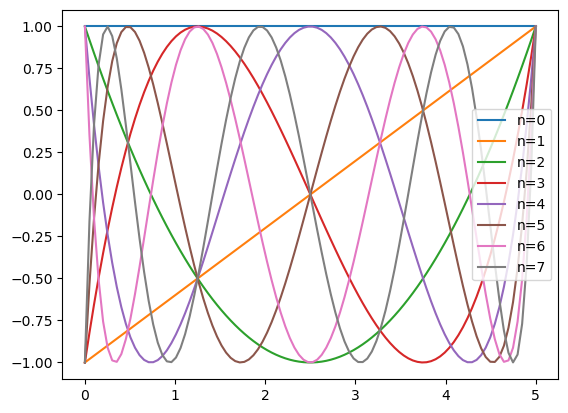

In [4]:
import matplotlib.pyplot as plt
num_basis=8
chev=make_radial("cheby", num_basis=8, rc=5.0, normalize=False)
label=torch.arange(num_basis)
x=torch.linspace(0,5,100)
y=chev(x)
plt.plot(x.numpy(), y.numpy(), label=[f"n={k}" for k in label]);
plt.legend()

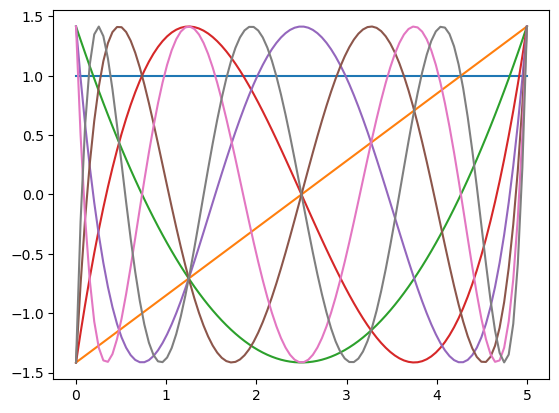

In [5]:
chev_norm=make_radial("cheby", num_basis=8, rc=5.0, normalize=True)
x=torch.linspace(0,5,100)
y=chev_norm(x)
plt.plot(x.numpy(), y.numpy());

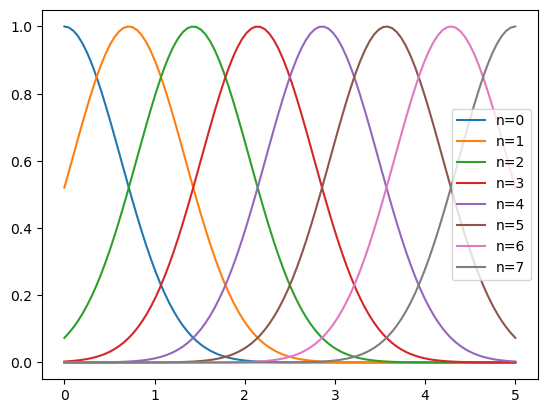

In [6]:
gauss=make_radial("gaussian", num_basis=8, rc=5.0, start=0.0)
label=torch.arange(num_basis)
x=torch.linspace(0,5,100)
y=gauss(x)
plt.plot(x.numpy(), y.numpy(), label=[f"n={k}" for k in label])
plt.legend()

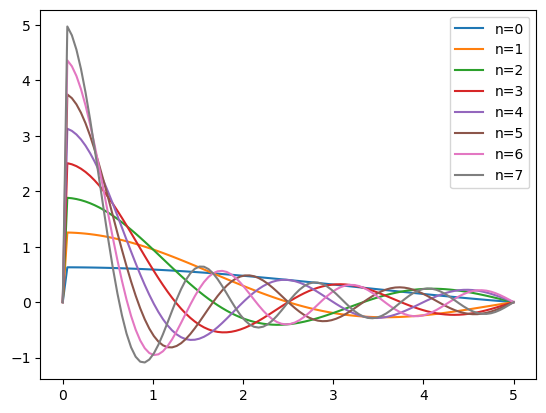

In [7]:
sinc=make_radial("sinc", num_basis=8, rc=5.0)
label=torch.arange(num_basis)
x=torch.linspace(0,5,100)
y=sinc(x)
plt.plot(x.numpy(), y.numpy(), label=[f"n={k}" for k in label])
plt.legend()

envelopeを作用させた場合

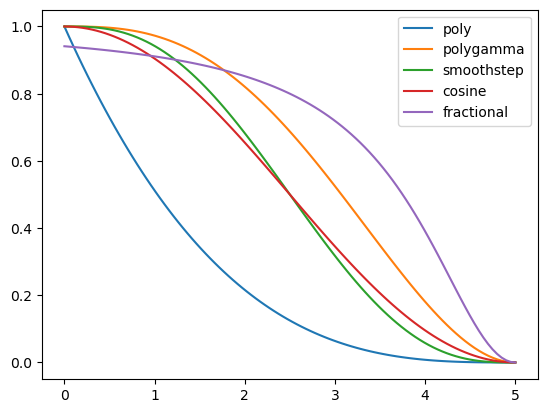

In [8]:
envelope_poly=make_envelope("poly", rc=5.0)
envelope_poly_gamma=make_envelope("polygamma", rc=5.0, gamma=3.0)
envelope_smoothstep=make_envelope("smoothstep", rc=5.0, order=3)
envelope_cos=make_envelope("cos", rc=5.0)
envelope_frac=make_envelope("fractional", rc=5.0, h=1.25)
scale_poly=envelope_poly(x)
scale_gamma=envelope_poly_gamma(x)
scale_smoothstep=envelope_smoothstep(x)
scale_cos=envelope_cos(x)
scale_frac=envelope_frac(x)
plt.plot(x.numpy(), scale_poly.numpy(), label="poly")
plt.plot(x.numpy(), scale_gamma.numpy(), label="polygamma")
plt.plot(x.numpy(), scale_smoothstep.numpy(), label="smoothstep")
plt.plot(x.numpy(), scale_cos.numpy(), label="cosine")
plt.plot(x.numpy(), scale_frac.numpy(), label="fractional")
plt.legend()

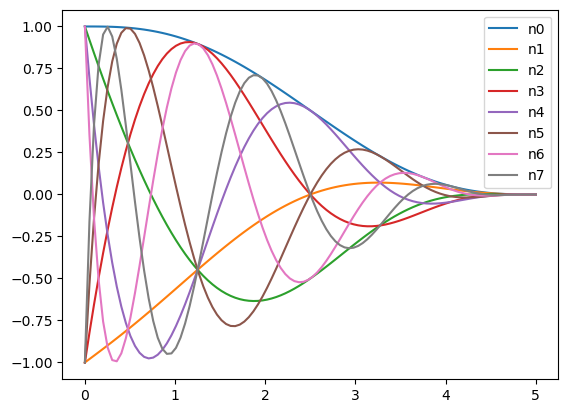

In [12]:
combo_cheby_smooth=scale_smoothstep*chev(x)
plt.plot(x.numpy(), combo_cheby_smooth.numpy(), label=['n{}'.format(k) for k in label])
plt.legend()

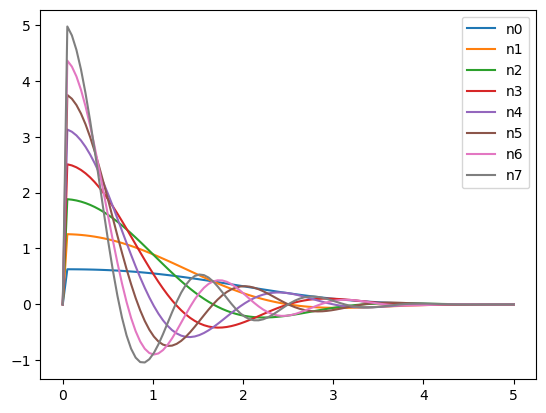

In [13]:
combo_sinc_smooth=scale_smoothstep*sinc(x)
plt.plot(x.numpy(), combo_sinc_smooth.numpy(), label=['n{}'.format(k) for k in label])
plt.legend()

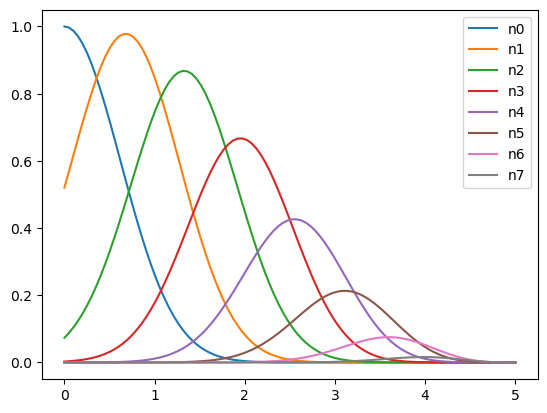

In [14]:
combo_gauss_smooth=scale_smoothstep*gauss(x)
plt.plot(x.numpy(), combo_gauss_smooth.numpy(), label=['n{}'.format(k) for k in label])
plt.legend()

Chebyshev基底関数 + smooth_step, Gaussian + smooth_stepが穏当そう